In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
import numpy as np
from scipy import stats
# from scipy.stats import chi2_contingency
from datetime import datetime, timedelta
import math
# import missingno as msno
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

# WHAT CAN WE DERIVE

## 1) Most targeted Destination IP Address
## 2) Most Logical Ports attacked
## 3) Most Frequently/common type of Attack
## 4) Different time of the day , (odd , hours, day or night)
## 5) Find the Pattern

In [3]:
df = pd.read_csv("Thesis_Data/Cybersecurity_attacks.csv")
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.,1421927414-1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.,1421927415-1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.,1421927416-1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.,1421927417-1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,.,1421927418-1421927418


In [4]:
# Shape of the dataset

df.shape

(178031, 11)

In [5]:
# Columns in Dataset

df.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', '.', 'Time'],
      dtype='object')

In [6]:
df.describe()

,Source Port,Destination Port
count,178031.000000,178031.000000
mean,16464.037252,1297.522769
std,22872.732950,7446.794928
min,0.000000,-1199.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,34558.500000,80.000000
max,79999.000000,65535.000000


### Null Value Check

In [7]:
df.isnull().sum()

Attack category           0
Attack subcategory     4192
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      51745
.                         0
Time                      0
dtype: int64

In [8]:
# Attack subcategory

# Let's fill the null value in this column as "Not Registered"

df["Attack subcategory"] = df["Attack subcategory"].fillna("Not Registered")

In [9]:
df.isnull().sum()

Attack category           0
Attack subcategory        0
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      51745
.                         0
Time                      0
dtype: int64

In [10]:
# Attack Reference

# Let's fill the null value in this column as "NA"

df["Attack Reference"] = df["Attack Reference"].fillna("NA")

In [11]:
df.isnull().sum()

Attack category       0
Attack subcategory    0
Protocol              0
Source IP             0
Source Port           0
Destination IP        0
Destination Port      0
Attack Name           0
Attack Reference      0
.                     0
Time                  0
dtype: int64

In [12]:
# Drop the Duplicates

df = df.drop(df[df.duplicated()].index)

In [13]:
df.shape

(178025, 11)

In [14]:
# Removing Invalid Value of Source Port and Destination Port

invalid_SP = (df['Source Port'] < 0) | (df['Source Port'] > 65535)
invalid_DP = (df['Destination Port'] < 0) | (df['Destination Port'] > 65535)

df = df[~(invalid_SP | invalid_DP)].reset_index(drop=True)

In [15]:
df.shape

(174341, 11)

In [16]:
print('Total number of different protocols:', len(df['Protocol'].unique()))

Total number of different protocols: 131


In [17]:
df['Protocol'].unique()[:15]

array(['tcp', 'udp', 'Tcp', 'UDP', 'ospf', 'sctp', 'sep', 'mobile',
       'sun-nd', 'swipe', 'pim', 'ggp', 'ip', 'ipnip', 'st2'],
      dtype=object)

In [18]:
df['Protocol'] = df['Protocol'].str.upper().str.strip()

In [19]:
print('Total number of different protocols:', len(df['Protocol'].unique()))

Total number of different protocols: 129


In [20]:
df['Attack category'].unique()

array(['Reconnaissance', 'Exploits', 'DoS', 'Generic', 'Shellcode',
       ' Fuzzers', 'Worms', 'Backdoors', 'Analysis', ' Fuzzers ',
       ' Reconnaissance ', 'Backdoor', ' Shellcode ', 'Reconnaissance '],
      dtype=object)

In [21]:
df['Attack category'] = df['Attack category'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.strip().replace('BACKDOORS','BACKDOOR')

In [22]:
print('Total number of different Attack categories:', len(df['Attack category'].unique()))

Total number of different Attack categories: 9


In [23]:
df.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', '.', 'Time'],
      dtype='object')

In [24]:
df[['Start time','Last time']] = df['Time'].str.split('-',expand=True)
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time,Start time,Last time
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.,1421927414-1421927416,1421927414,1421927416
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.,1421927415-1421927415,1421927415,1421927415
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.,1421927416-1421927416,1421927416,1421927416
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.,1421927417-1421927417,1421927417,1421927417
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,.,1421927418-1421927418,1421927418,1421927418


In [25]:
df = df.drop(['.', 'Time'],axis=1)# Drop columns and make a copy in memory of the object
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418


In [26]:
df.isnull().sum()

Attack category       0
Attack subcategory    0
Protocol              0
Source IP             0
Source Port           0
Destination IP        0
Destination Port      0
Attack Name           0
Attack Reference      0
Start time            0
Last time             0
dtype: int64

In [27]:
df_tcp = pd.read_csv("Thesis_Data/TCP-ports.xls")
df_tcp.head()

,Port,Service,Description
0,0,NaN,Reserved
1,1,tcpmux,TCP Port Service Multiplexer
2,2,compressnet,Management Utility
3,3,compressnet,Compression Process
4,5,rje,Remote Job Entry


In [28]:
df_tcp['Service'] = df_tcp['Service'].str.upper()

In [29]:
df_tcp.head()

,Port,Service,Description
0,0,NaN,Reserved
1,1,TCPMUX,TCP Port Service Multiplexer
2,2,COMPRESSNET,Management Utility
3,3,COMPRESSNET,Compression Process
4,5,RJE,Remote Job Entry


In [30]:
print('Dimensions before merging dataframes: ' ,(df.shape))

newdf = pd.merge(df, df_tcp[['Port','Service']], left_on='Destination Port', right_on='Port', how='left')
newdf = newdf.rename(columns={'Service':'Destination Port Service'})

print('Dimensions after merging dataframes: ' + str(newdf.shape))

Dimensions before merging dataframes:  (174341, 11)
Dimensions after merging dataframes: (174341, 13)


In [31]:
newdf = newdf.drop(columns=['Port'])
newdf.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416,HTTP
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415,NaN
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416,HTTP
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417,PERSONAL-AGENT
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418,HTTP




# Univariate Analysis

In [32]:
# Attack Category

df['Attack category'].value_counts()

EXPLOITS          68211
FUZZERS           33638
DOS               24582
RECONNAISSANCE    20136
GENERIC           19860
BACKDOOR           4353
ANALYSIS           1881
SHELLCODE          1511
WORMS               169
Name: Attack category, dtype: int64

Text(0, 0.5, 'Frequency')

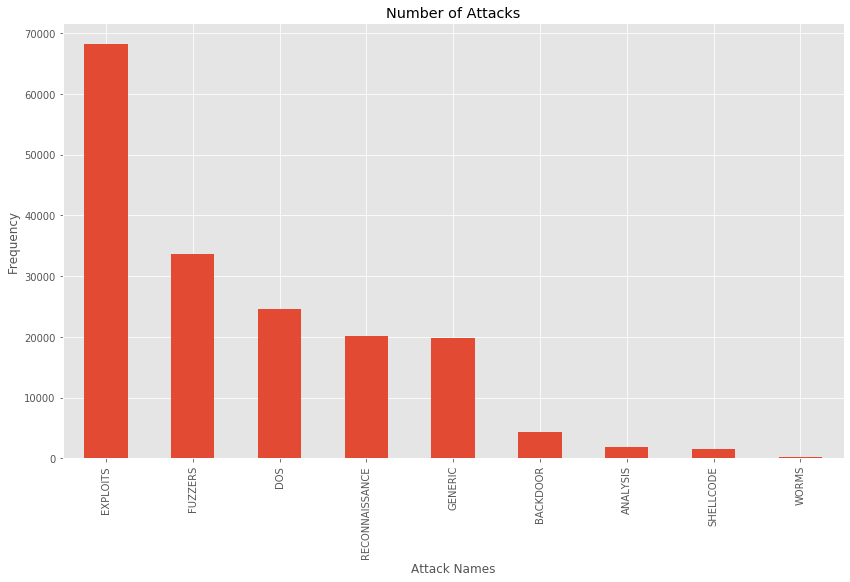

In [33]:
ax = df['Attack category'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Attacks")
ax.set_xlabel("Attack Names")
ax.set_ylabel("Frequency")

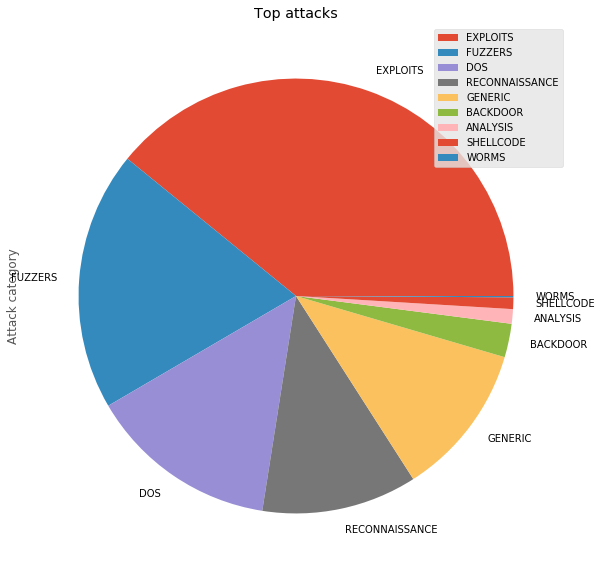

In [34]:
p = pd.DataFrame(df['Attack category'].value_counts())
p.plot(kind='pie', subplots=True, figsize=(10, 10))
plt.title('Top attacks')
plt.legend(loc='left')
plt.show()

In [35]:
# Attack subcategory

df['Attack subcategory'].value_counts()

Miscellaneous    38679
IXIA             16606
 OSPF            12930
 ICMP            11207
SMB               8707
                 ...  
Dameware             1
SCTP                 1
 SOCKS               1
 HTTP                1
All                  1
Name: Attack subcategory, Length: 164, dtype: int64

In [36]:
# Protocol

df['Protocol'].value_counts()

TCP          56596
UDP          27078
UNAS         24716
OSPF          9521
SCTP          4348
             ...  
BNA            389
IPV6-OPTS      389
VINES          389
WSN            389
XNET           389
Name: Protocol, Length: 129, dtype: int64

In [37]:
# Source IP

df['Source IP'].value_counts()

175.45.176.1    51645
175.45.176.0    50444
175.45.176.3    39009
175.45.176.2    33243
Name: Source IP, dtype: int64

Text(0, 0.5, 'Frequency')

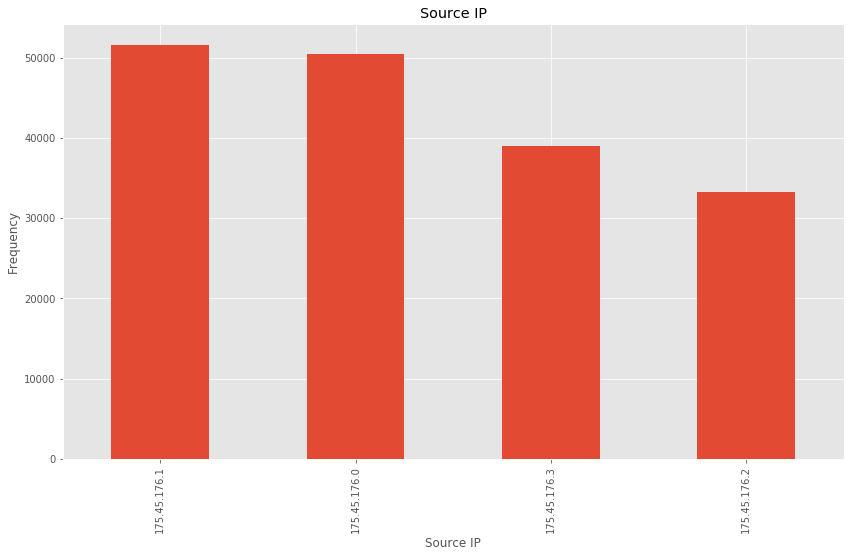

In [38]:
ax = df['Source IP'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Source IP")
ax.set_xlabel("Source IP")
ax.set_ylabel("Frequency")

In [39]:
# Source Port

df['Source Port'].value_counts()

0        90701
1043      6693
47439     6690
137        519
68         158
         ...  
11953        1
16051        1
3765         1
5814         1
34735        1
Name: Source Port, Length: 40498, dtype: int64

In [40]:
# Destination IP

df['Destination IP'].value_counts()

149.171.126.17    43199
149.171.126.10    24002
149.171.126.19    21619
149.171.126.13    20464
149.171.126.18    13301
149.171.126.14    12195
149.171.126.12    11970
149.171.126.15    10555
149.171.126.11     9444
149.171.126.16     7592
Name: Destination IP, dtype: int64

Text(0, 0.5, 'Frequency')

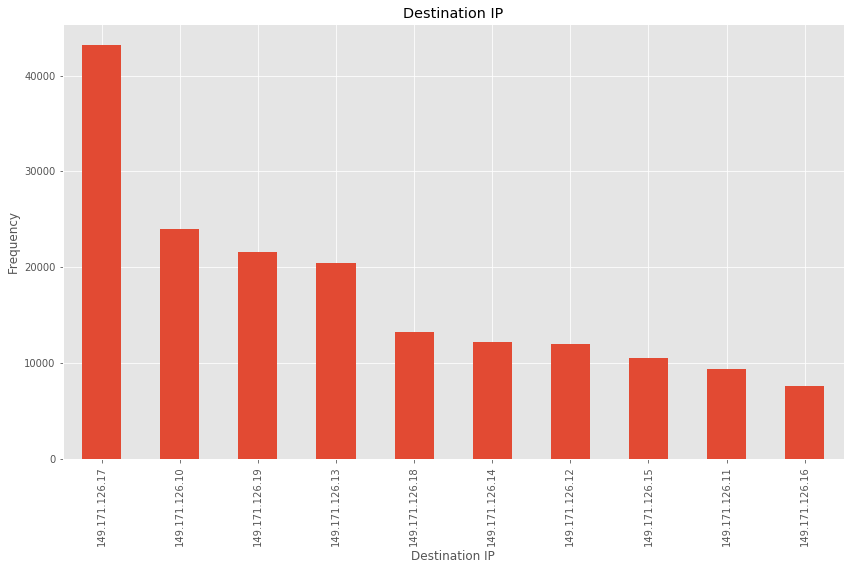

In [41]:
ax = df['Destination IP'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Destination IP")
ax.set_xlabel("Destination IP")
ax.set_ylabel("Frequency")

In [42]:
# Destination Port

df['Destination Port'].value_counts()

0        90701
80       19253
53       13842
111       9615
179       5466
         ...  
1992         1
65239        1
14030        1
58964        1
40365        1
Name: Destination Port, Length: 3182, dtype: int64

In [43]:
newdf['Start time'] = pd.to_datetime(newdf['Start time'], unit='s')
newdf['Last time'] = pd.to_datetime(newdf['Last time'], unit='s')
newdf['Duration'] = ((newdf['Last time'] - newdf['Start time']).dt.seconds).astype(int)

In [44]:
newdf.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,HTTP,2
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,NaN,0
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,HTTP,0
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,PERSONAL-AGENT,0
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,HTTP,0


In [45]:
newdf.describe()

,Source Port,Destination Port,Duration
count,174341.000000,174341.000000,174341.000000
mean,15391.130382,1304.599423,2.341572
std,21707.824000,7466.035607,9.309381
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,31862.000000,80.000000,1.000000
max,65535.000000,65535.000000,60.000000


In [46]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174341 entries, 0 to 174340
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Attack category           174341 non-null  object        
 1   Attack subcategory        174341 non-null  object        
 2   Protocol                  174341 non-null  object        
 3   Source IP                 174341 non-null  object        
 4   Source Port               174341 non-null  int64         
 5   Destination IP            174341 non-null  object        
 6   Destination Port          174341 non-null  int64         
 7   Attack Name               174341 non-null  object        
 8   Attack Reference          174341 non-null  object        
 9   Start time                174341 non-null  datetime64[ns]
 10  Last time                 174341 non-null  datetime64[ns]
 11  Destination Port Service  78799 non-null   object        
 12  Du

Target variable -

0 - Non-threat
1 - Threat

In [47]:
newdf['Attack category'].value_counts()

EXPLOITS          68211
FUZZERS           33638
DOS               24582
RECONNAISSANCE    20136
GENERIC           19860
BACKDOOR           4353
ANALYSIS           1881
SHELLCODE          1511
WORMS               169
Name: Attack category, dtype: int64

In [48]:
t = []

l = ['GENERIC', 'BACKDOOR', 'ANALYSIS', 'SHELLCODE', 'WORMS']

for attack in newdf['Attack category']:
    
    if attack in l:
        t.append(0)
    else:
        t.append(1)

In [49]:
newdf['Class'] = t

In [50]:
newdf.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration,Class
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,HTTP,2,1
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,NaN,0,1
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,HTTP,0,1
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,PERSONAL-AGENT,0,1
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,HTTP,0,1


In [51]:
newdf.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', 'Start time', 'Last time',
       'Destination Port Service', 'Duration', 'Class'],
      dtype='object')

In [52]:
newdf.shape

(174341, 14)

In [53]:
newdf['Start time'].value_counts()

2015-02-18 01:32:27    613
2015-02-18 05:27:39    577
2015-02-18 03:29:54    513
2015-02-18 09:25:58    497
2015-02-18 11:25:41    477
                      ... 
2015-02-18 09:19:11      1
2015-02-18 04:27:47      1
2015-02-18 03:17:42      1
2015-02-18 06:57:45      1
2015-01-22 12:15:37      1
Name: Start time, Length: 43070, dtype: int64

Let's remove some columns to create dummy variables and model building.


In [54]:
model_df = newdf

In [55]:
model_df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration,Class
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,HTTP,2,1
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,NaN,0,1
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,HTTP,0,1
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,PERSONAL-AGENT,0,1
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,HTTP,0,1


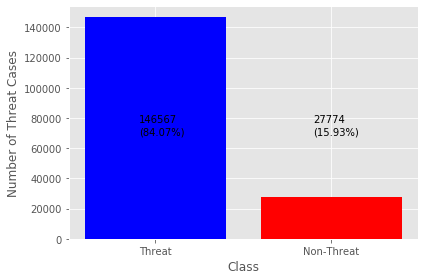

In [56]:
plt.bar(['Threat','Non-Threat'], newdf['Class'].value_counts(), color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of Threat Cases')
plt.annotate('{}\n({:.4}%)'.format(newdf['Class'].value_counts()[1], 
                                         newdf['Class'].value_counts()[1]/newdf['Class'].count()*100),
             (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}\n({:.4}%)'.format(newdf['Class'].value_counts()[0], 
                                         newdf['Class'].value_counts()[0]/newdf['Class'].count()*100),
             (0.70, 0.45), xycoords='axes fraction')
plt.tight_layout()
plt.show()

In [57]:
newdf.corr(method='pearson')

,Source Port,Destination Port,Duration,Class
Source Port,1.000000,0.137155,-0.078024,-0.077630
Destination Port,0.137155,1.000000,-0.026770,-0.056401
Duration,-0.078024,-0.026770,1.000000,0.056335
Class,-0.077630,-0.056401,0.056335,1.000000


In [58]:
newdf.corr(method='spearman')

,Source Port,Destination Port,Duration,Class
Source Port,1.000000,0.885328,0.361013,-0.142772
Destination Port,0.885328,1.000000,0.346909,-0.092411
Duration,0.361013,0.346909,1.000000,0.144881
Class,-0.142772,-0.092411,0.144881,1.000000


In [59]:
df_dummies = pd.get_dummies(newdf, columns=['Attack category', 'Source IP', 'Destination IP'])

In [60]:
df_dummies

,Attack subcategory,Protocol,Source Port,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration,...,Destination IP_149.171.126.10,Destination IP_149.171.126.11,Destination IP_149.171.126.12,Destination IP_149.171.126.13,Destination IP_149.171.126.14,Destination IP_149.171.126.15,Destination IP_149.171.126.16,Destination IP_149.171.126.17,Destination IP_149.171.126.18,Destination IP_149.171.126.19
0,HTTP,TCP,13284,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,HTTP,2,...,0,0,0,0,0,0,1,0,0,0
1,Unix 'r' Service,UDP,21223,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,NaN,0,...,0,0,0,0,0,0,0,0,1,0
2,Browser,TCP,23357,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,HTTP,0,...,0,0,0,0,0,0,1,0,0,0
3,Miscellaneous Batch,TCP,13792,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,PERSONAL-AGENT,0,...,0,0,0,0,0,0,1,0,0,0
4,Cisco IOS,TCP,26939,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,HTTP,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174336,IGMP,TCP,33654,80,Microsoft IIS Repeated Parameter Request Denia...,CVE 2010-1899 (http://cve.mitre.org/cgi-bin/cv...,2015-02-18 12:21:06,2015-02-18 12:21:09,HTTP,3,...,0,0,1,0,0,0,0,0,0,0
174337,SMB,TCP,36468,445,Fuzzer: SMB Session Setup Invalid Username (NT...,NA,2015-02-18 12:21:07,2015-02-18 12:21:08,MICROSOFT-DS,1,...,0,0,0,0,0,1,0,0,0,0
174338,SunRPC Portmapper (TCP) UDP Service,TCP,64395,111,SunRPC TCP Portmapper GETPORT Request (ippathv...,NA,2015-02-18 12:21:07,2015-02-18 12:21:08,SUNRPC,1,...,0,0,0,0,0,0,0,0,1,0
174339,IXIA,UDP,47439,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,2015-02-18 12:21:08,2015-02-18 12:21:08,DOMAIN,0,...,1,0,0,0,0,0,0,0,0,0


In [61]:
df_dummies.columns

Index(['Attack subcategory', 'Protocol', 'Source Port', 'Destination Port',
       'Attack Name', 'Attack Reference', 'Start time', 'Last time',
       'Destination Port Service', 'Duration', 'Class',
       'Attack category_ANALYSIS', 'Attack category_BACKDOOR',
       'Attack category_DOS', 'Attack category_EXPLOITS',
       'Attack category_FUZZERS', 'Attack category_GENERIC',
       'Attack category_RECONNAISSANCE', 'Attack category_SHELLCODE',
       'Attack category_WORMS', 'Source IP_175.45.176.0',
       'Source IP_175.45.176.1', 'Source IP_175.45.176.2',
       'Source IP_175.45.176.3', 'Destination IP_149.171.126.10',
       'Destination IP_149.171.126.11', 'Destination IP_149.171.126.12',
       'Destination IP_149.171.126.13', 'Destination IP_149.171.126.14',
       'Destination IP_149.171.126.15', 'Destination IP_149.171.126.16',
       'Destination IP_149.171.126.17', 'Destination IP_149.171.126.18',
       'Destination IP_149.171.126.19'],
      dtype='object')

In [62]:
df_dummies = df_dummies.drop(['Attack subcategory', 'Protocol', 'Attack Name', 'Attack Reference', 'Start time', 'Last time', 'Destination Port Service'],axis=1)

In [63]:
df_dummies.columns

Index(['Source Port', 'Destination Port', 'Duration', 'Class',
       'Attack category_ANALYSIS', 'Attack category_BACKDOOR',
       'Attack category_DOS', 'Attack category_EXPLOITS',
       'Attack category_FUZZERS', 'Attack category_GENERIC',
       'Attack category_RECONNAISSANCE', 'Attack category_SHELLCODE',
       'Attack category_WORMS', 'Source IP_175.45.176.0',
       'Source IP_175.45.176.1', 'Source IP_175.45.176.2',
       'Source IP_175.45.176.3', 'Destination IP_149.171.126.10',
       'Destination IP_149.171.126.11', 'Destination IP_149.171.126.12',
       'Destination IP_149.171.126.13', 'Destination IP_149.171.126.14',
       'Destination IP_149.171.126.15', 'Destination IP_149.171.126.16',
       'Destination IP_149.171.126.17', 'Destination IP_149.171.126.18',
       'Destination IP_149.171.126.19'],
      dtype='object')

In [64]:
y= df_dummies['Class'] #class variable
X = df_dummies.drop(columns = ['Class'])

print(y.shape)
print(X.shape)

(174341,)
(174341, 26)


In [65]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import scipy as sp
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Classifier Libraries
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,classification_report

import collections

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from imblearn import over_sampling
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

In [66]:
from sklearn import model_selection

# Stratify = yes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [67]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

146567
102596
43971


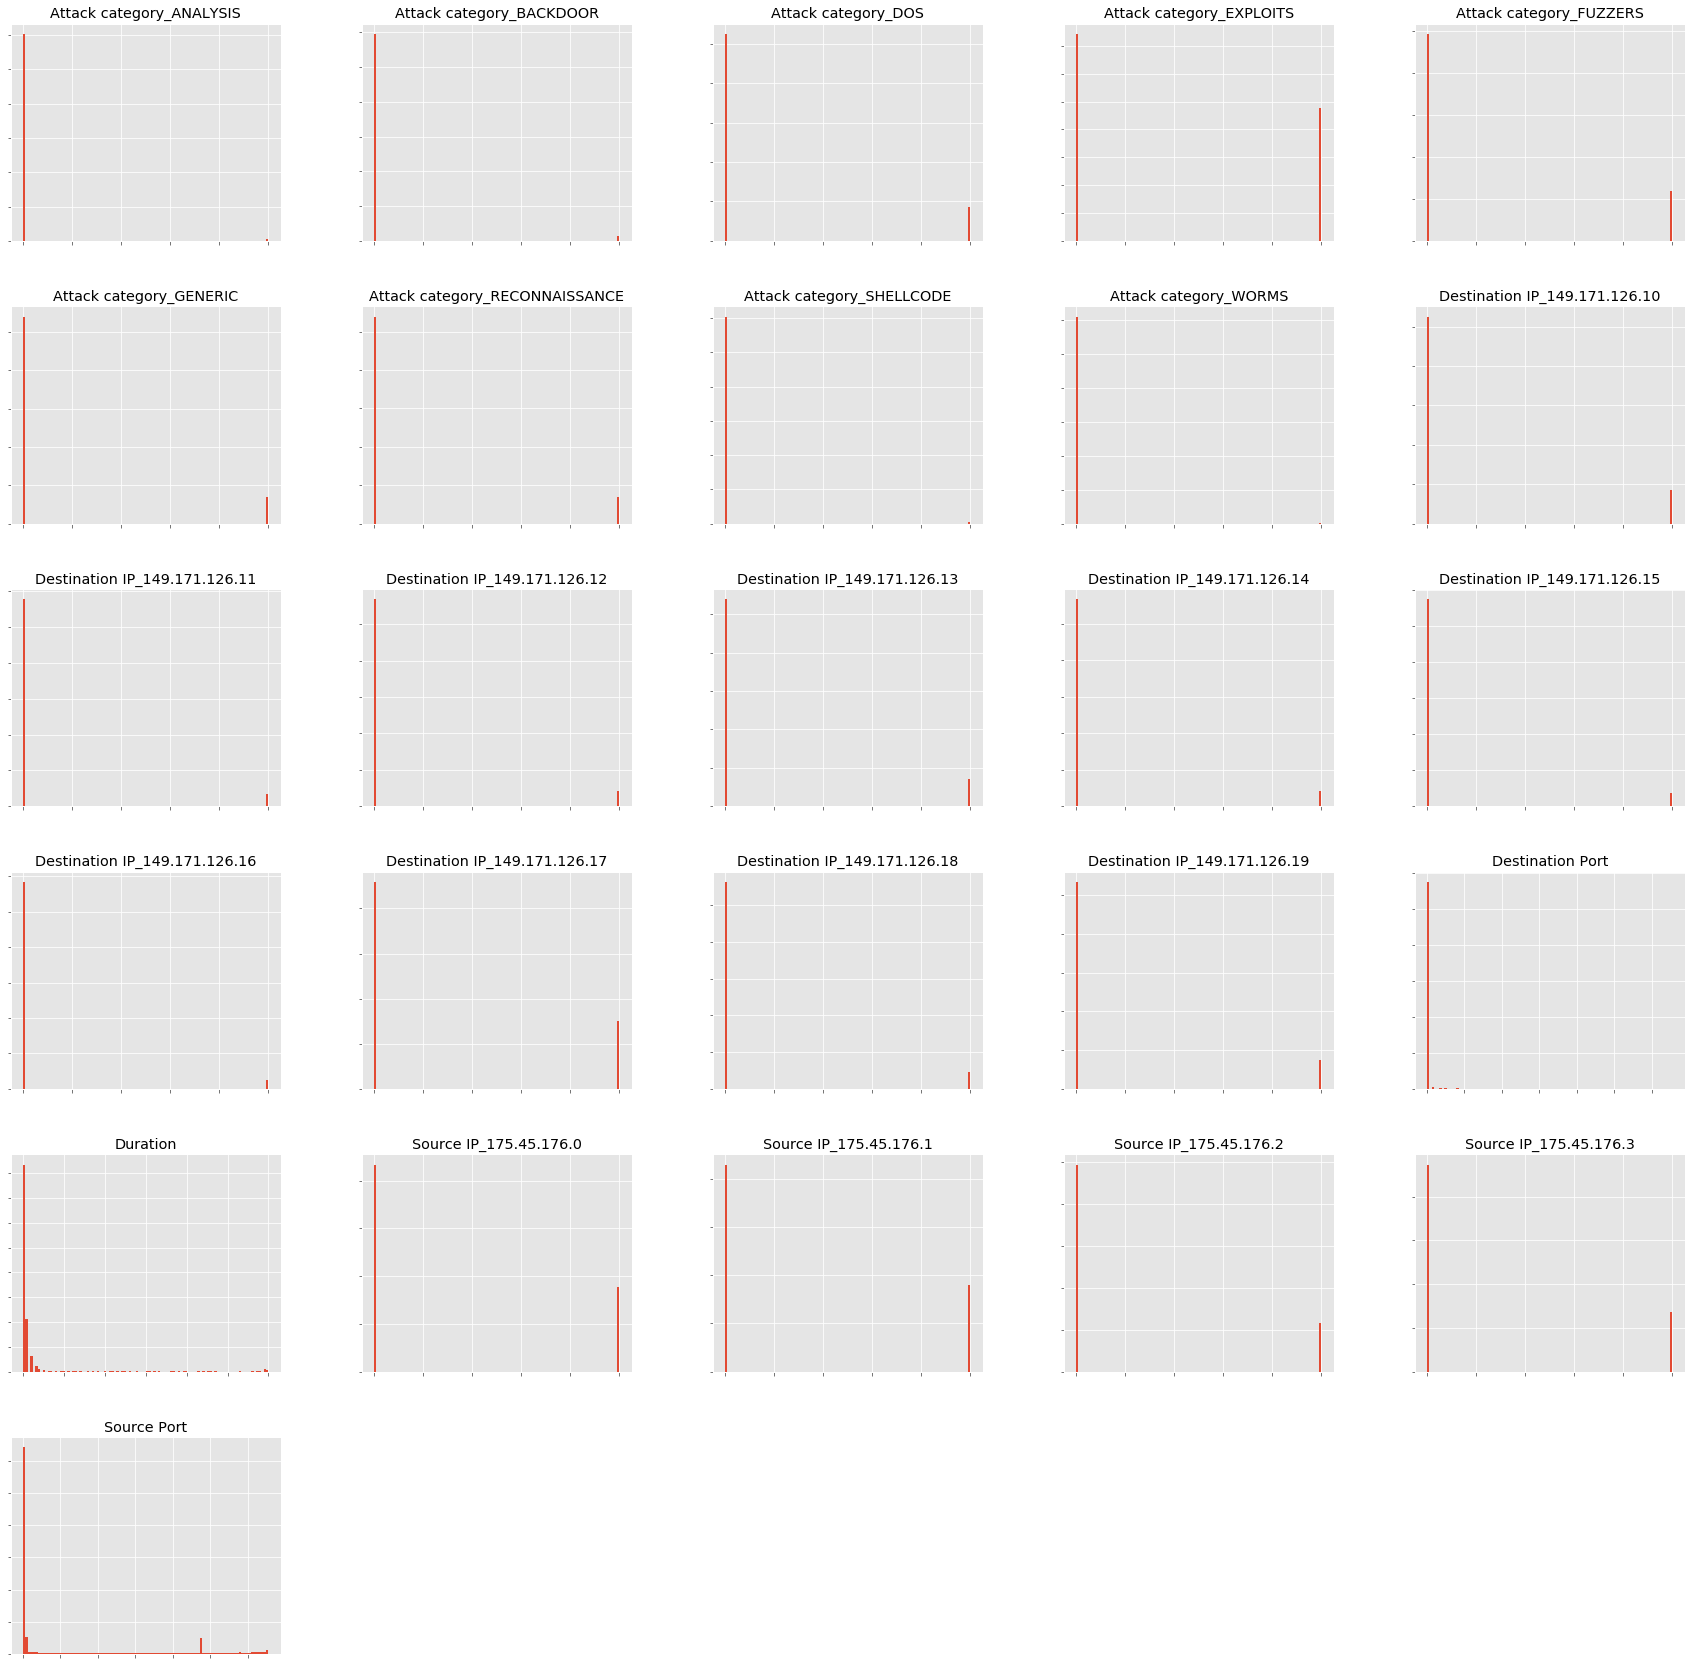

In [68]:
ax = X_train.hist(bins = 100, figsize = (30,30))
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

plt.show()

In [70]:
skew_ = df_dummies.skew()
skew_

Source Port                        1.048011
Destination Port                   6.921235
Duration                           5.206402
Class                             -1.861904
Attack category_ANALYSIS           9.470888
Attack category_BACKDOOR           6.089090
Attack category_DOS                2.063114
Attack category_EXPLOITS           0.445671
Attack category_FUZZERS            1.556268
Attack category_GENERIC            2.430465
Attack category_RECONNAISSANCE     2.406004
Attack category_SHELLCODE         10.601504
Attack category_WORMS             32.072141
Source IP_175.45.176.0             0.929134
Source IP_175.45.176.1             0.892575
Source IP_175.45.176.2             1.574829
Source IP_175.45.176.3             1.325718
Destination IP_149.171.126.10      2.103172
Destination IP_149.171.126.11      3.939295
Destination IP_149.171.126.12      3.411561
Destination IP_149.171.126.13      2.377496
Destination IP_149.171.126.14      3.372167
Destination IP_149.171.126.15   

In [71]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data

pt = PowerTransformer(copy=False, method='yeo-johnson', standardize=True)
pt.fit(X_train)
pt.transform(X_train)
pt.fit(X_test)

pt.transform(X_test)

array([[-0.95132442, -0.93469538, -0.66589383, ..., -0.57223563,
        -0.28885746, -0.37558631],
       [-0.95132442, -0.93469538, -0.66589383, ..., -0.57223563,
        -0.28885746,  2.66250384],
       [ 1.22389122,  1.31345234, -0.66589383, ..., -0.57223563,
        -0.28885746, -0.37558631],
       ...,
       [ 0.53219134,  0.75846044, -0.66589383, ..., -0.57223563,
        -0.28885746, -0.37558631],
       [ 1.17004216,  0.9611235 , -0.66589383, ..., -0.57223563,
        -0.28885746,  2.66250384],
       [ 1.19821372,  0.87422604, -0.66589383, ..., -0.57223563,
         3.46191508, -0.37558631]])

In [72]:
# Logistic Regression
from sklearn import linear_model #import the package
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

num_C = np.logspace(-5, 8, 15)
cv_num = 10   #--> list of values

In [73]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [74]:
#perform cross validation

print("=========For Logistic Regression================")

pred = cross_val_score(log_reg, X_train, y_train, cv=cv_num)
print("pred accuracy = " , metrics.accuracy_score(y_train, log_reg.predict(X_train)))


#perform hyperparameter tuning

param_grid = {'C': num_C}
logreg_cv = GridSearchCV(log_reg, param_grid, cv = 5)
logreg_cv.fit(X_train, y_train)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))  

#print the evaluation result by choosing a evaluation metric
confusion_matrix = metrics.confusion_matrix(y_train, log_reg.predict(X_train))
classification = metrics.classification_report(y_train, log_reg.predict(X_train))
print(confusion_matrix)
print(classification)

#print the optimum value of hyperparameters

print("Optimum value of hyperparameters is {}".format(logreg_cv.best_score_))

=========For Logistic Regression================
pred accuracy =  0.987479309723201
Tuned Logistic Regression Parameters: {'C': 31.622776601683793}
[[ 18405   1037]
 [   491 102105]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     19442
           1       0.99      1.00      0.99    102596

    accuracy                           0.99    122038
   macro avg       0.98      0.97      0.98    122038
weighted avg       0.99      0.99      0.99    122038

Optimum value of hyperparameters is 0.981218824848581


### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

In [75]:
# Random Forest

rdf = RandomForestClassifier(random_state=0)
rdf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [76]:
#perform cross validation

from sklearn.model_selection import RandomizedSearchCV

print("=========For Random Forest================")

print("pred accuracy = " , metrics.accuracy_score(y_train, rdf.predict(X_train)))

 
#print the evaluation result by choosing a evaluation metric
confusion_matrix = metrics.confusion_matrix(y_train, rdf.predict(X_train))
classification = metrics.classification_report(y_train, rdf.predict(X_train))
print(confusion_matrix)
print(classification)

 

=========For Random Forest================
pred accuracy =  1.0
[[ 19442      0]
 [     0 102596]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19442
           1       1.00      1.00      1.00    102596

    accuracy                           1.00    122038
   macro avg       1.00      1.00      1.00    122038
weighted avg       1.00      1.00      1.00    122038



In [77]:
# Train KNN Model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of KNN on the testing dataset is :{:.3f}'.format(knn.score(X_test,y_test)))

Accuracy of KNN on the testing dataset is :0.965


In [78]:
# Decision Tree

dct = DecisionTreeClassifier(random_state=0)
dct.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [80]:
param_dist = {"max_depth": [3, None], 
              "max_features": randint(1, 9), 
              "min_samples_leaf": randint(1, 9), 
              "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(dct, param_dist, cv = 5)
tree_cv.fit(X_train, y_train)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 4}
Best score is 0.9999508357915439


In [81]:
#Train XGBoost model
xg = XGBClassifier()
xg.fit(X_train, y_train)
print('Accuracy of XG on the testing dataset is :{:.3f}'.format(xg.score(X_test,y_test)))

Accuracy of XG on the testing dataset is :1.000


According to the accuracy of different models - 

Logistic Regression - 98.12%                                                                                           
Random Forest - 100%                                                                                                   
KNN - 96.5%                                                                                                                
XgBoost - 100%                                                                                                             
Decision Tree - 99.9%

So, we'll choose Random Forest model for our calculation.

#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [100]:
clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0,max_features = 'auto', max_depth = 10)
clf.fit(X_train, y_train)


from sklearn.metrics import confusion_matrix
predicted = clf.predict(X_test)
predicted_proba = clf.predict_proba(X_test)

matrix = confusion_matrix(y_test, predicted)

print(matrix)

[[ 8332     0]
 [    0 43971]]


Top var = 9
2nd Top var = 7
3rd Top var = 5


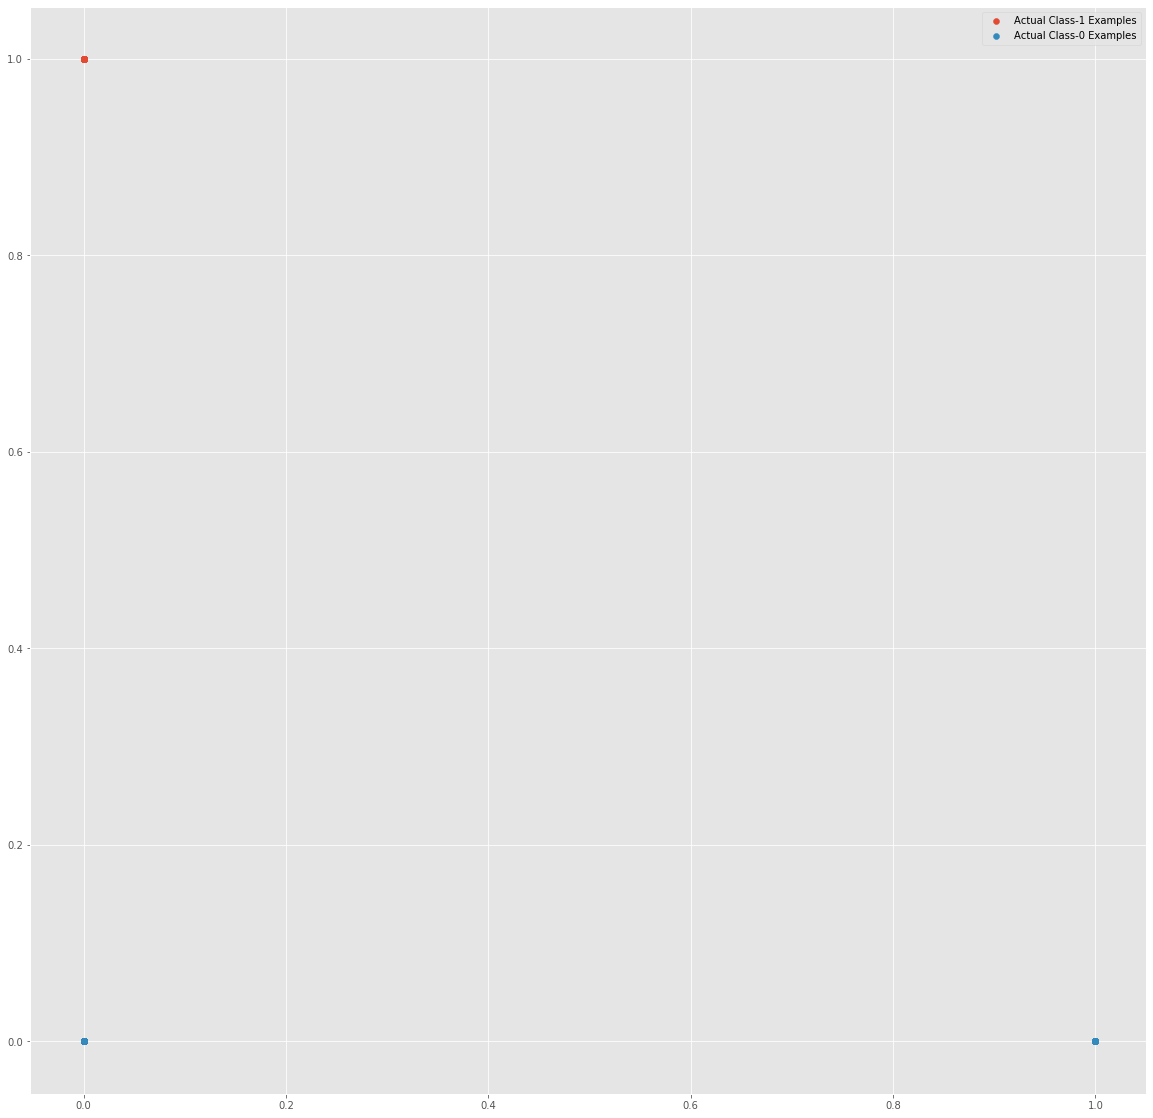

In [90]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [132]:
newdf.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration,Class
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,HTTP,2,1
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,NaN,0,1
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,HTTP,0,1
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,PERSONAL-AGENT,0,1
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,HTTP,0,1


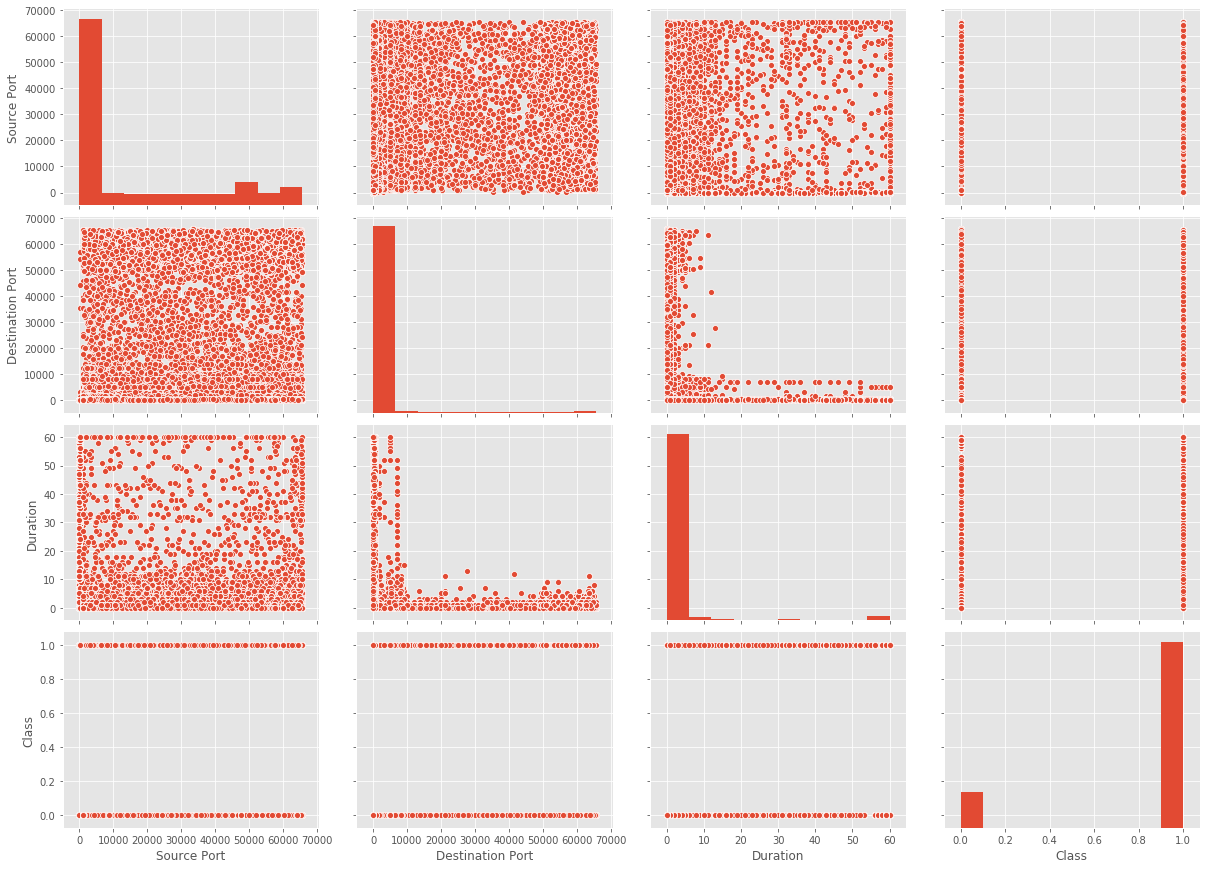

In [134]:
g = sns.pairplot(newdf)
g.fig.set_size_inches(17,12)
plt.show()

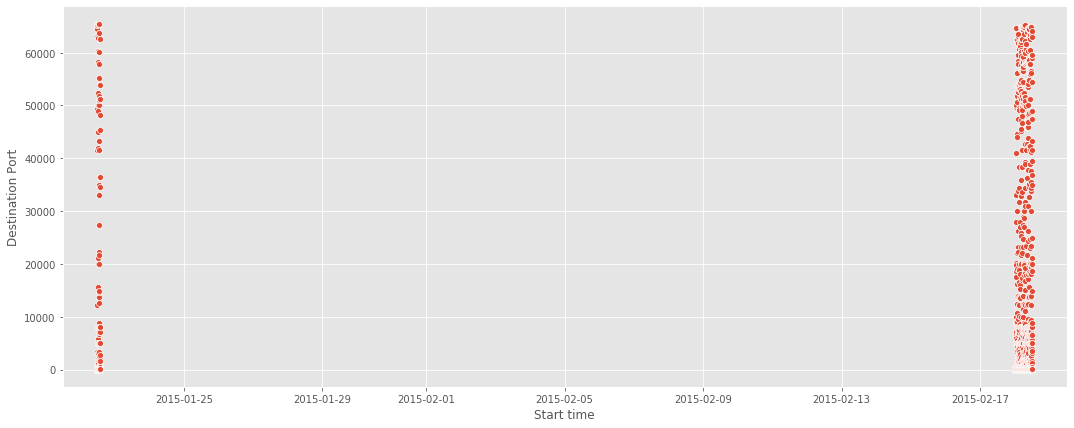

In [135]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min()-timedelta(days=1),right=newdf['Start time'].max()+timedelta(days=1))
plt.grid(True)
plt.show()

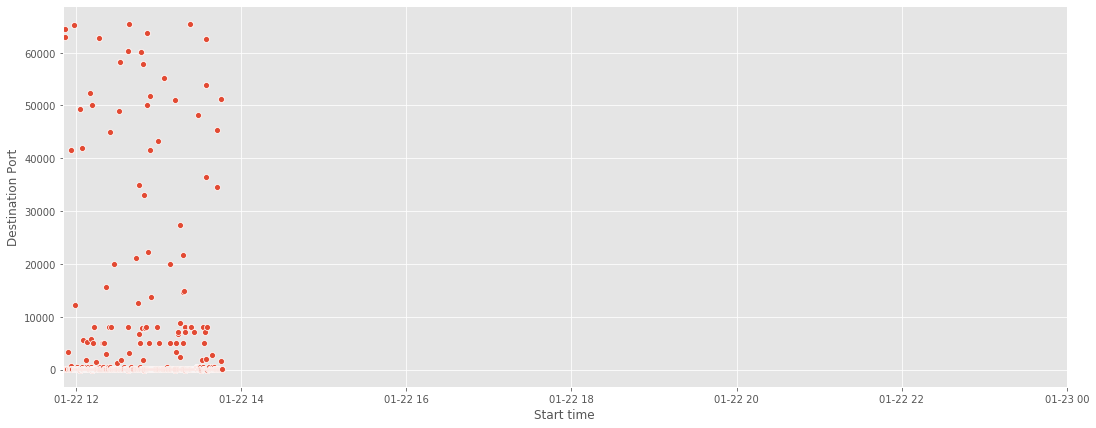

In [136]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min(),right=datetime.strptime('15-01-23', '%y-%m-%d'))
plt.grid(True)
plt.show()


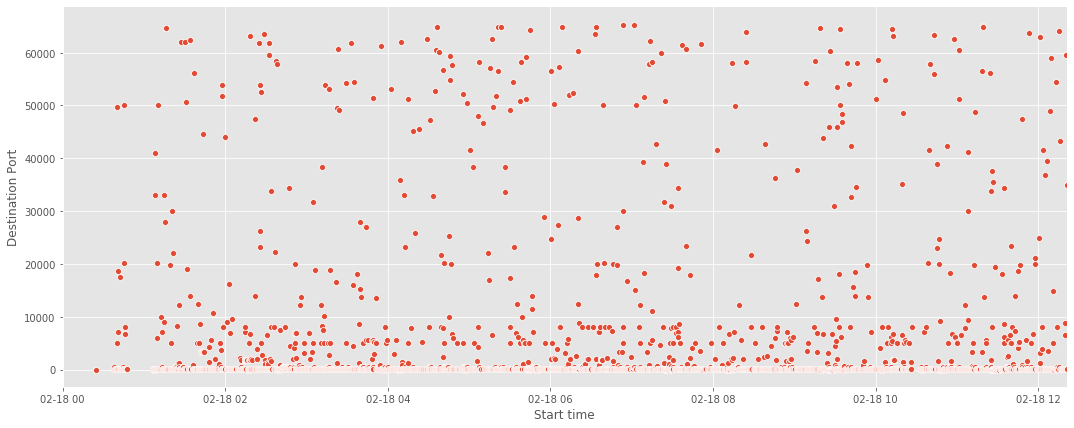

In [137]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=datetime.strptime('15-02-18', '%y-%m-%d'),right=newdf['Start time'].max())
plt.grid(True)
plt.show()

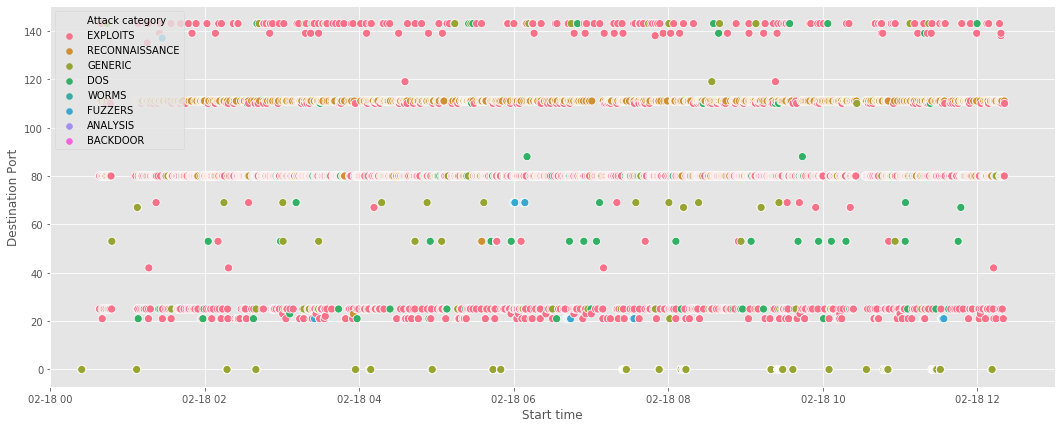

In [138]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Start time', y='Destination Port', hue='Attack category', 
                data=newdf[(newdf['Destination IP']=='149.171.126.17')&(newdf['Destination Port']<=150)], 
                s=65)
plt.xlim(left=datetime.strptime('15-02-18 00:00:00', '%y-%m-%d %H:%M:%S'),
         right=datetime.strptime('15-02-18 13:00:00', '%y-%m-%d %H:%M:%S'))
plt.grid(True)
plt.show()

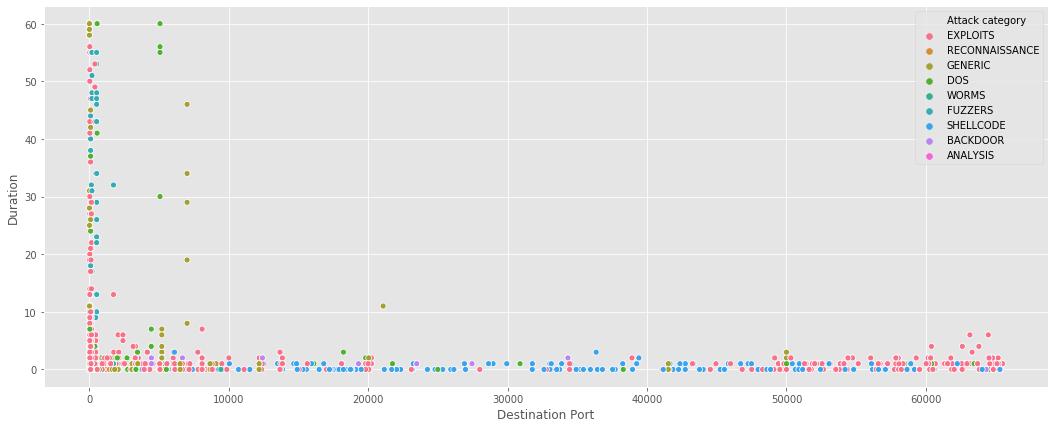

In [139]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Destination Port', y='Duration', hue='Attack category', data=newdf[newdf['Destination IP']=='149.171.126.17'])
plt.grid(True)
plt.show()

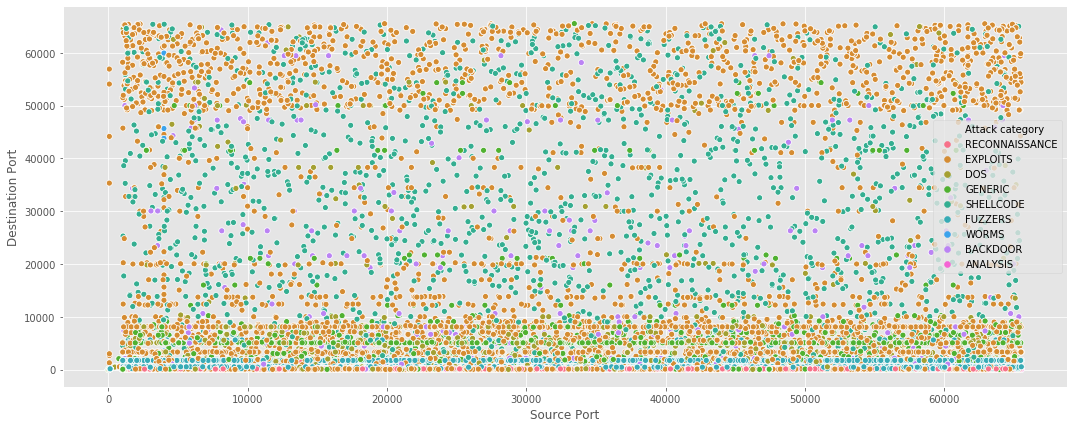

In [140]:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Source Port',y='Destination Port', hue='Attack category',data=newdf)
plt.show()

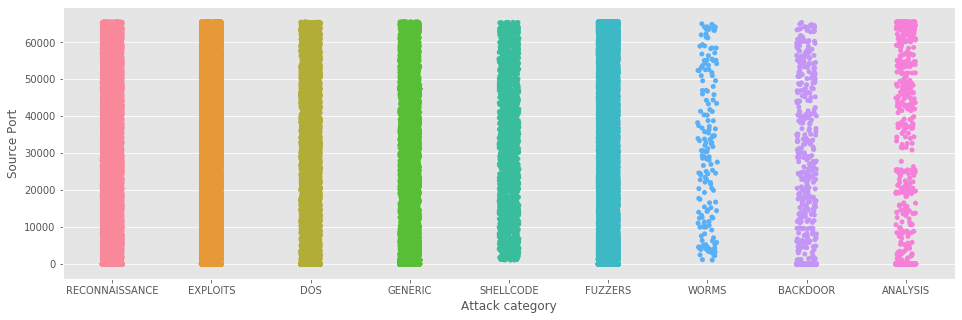

In [141]:
# Source ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Source Port',data=newdf)
plt.show()

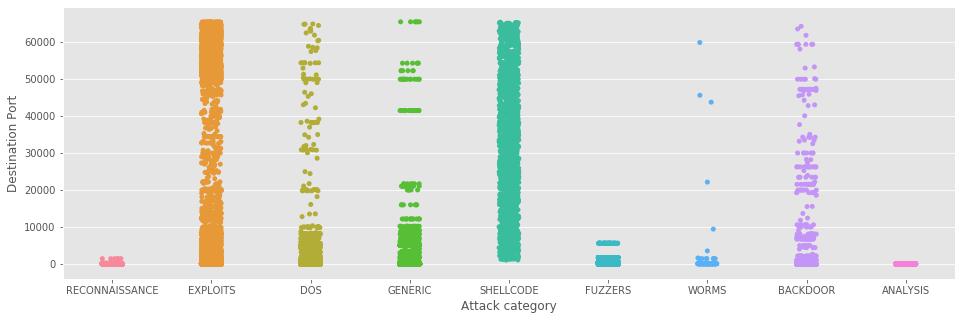

In [142]:

# Destination ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Destination Port',data=newdf)
plt.show()

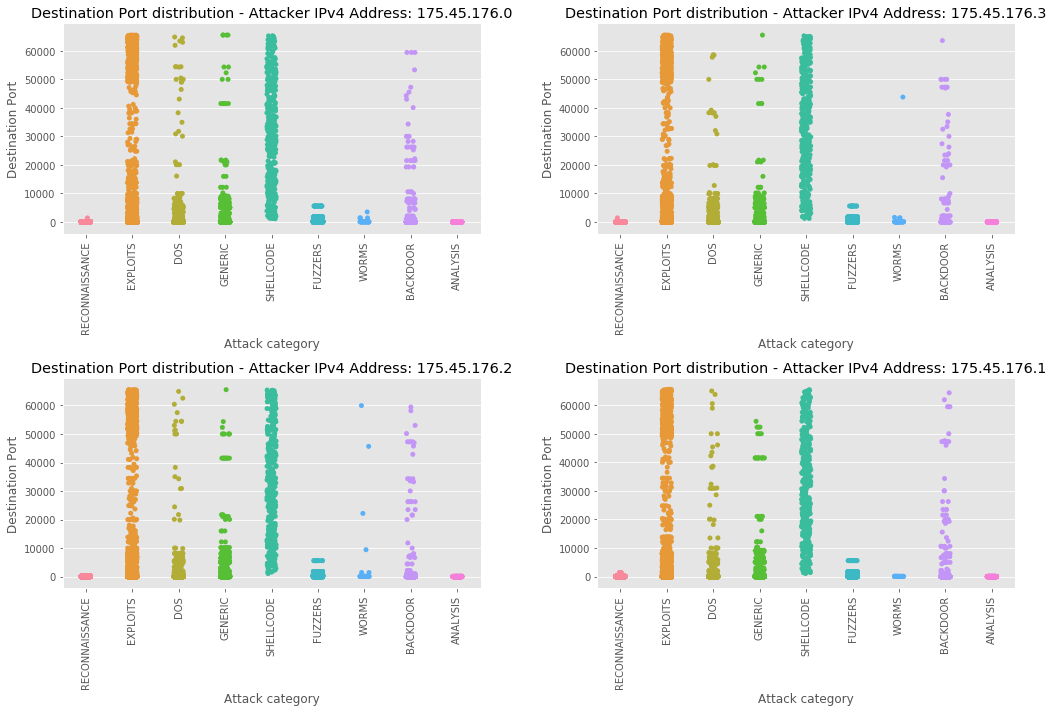

In [143]:
ips = list(newdf['Source IP'].unique())
f, axes = plt.subplots(2, 2)
f.set_figheight(10)
f.set_figwidth(15)

labels = list(newdf['Attack category'].unique())
for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=newdf[newdf['Source IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Attacker IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

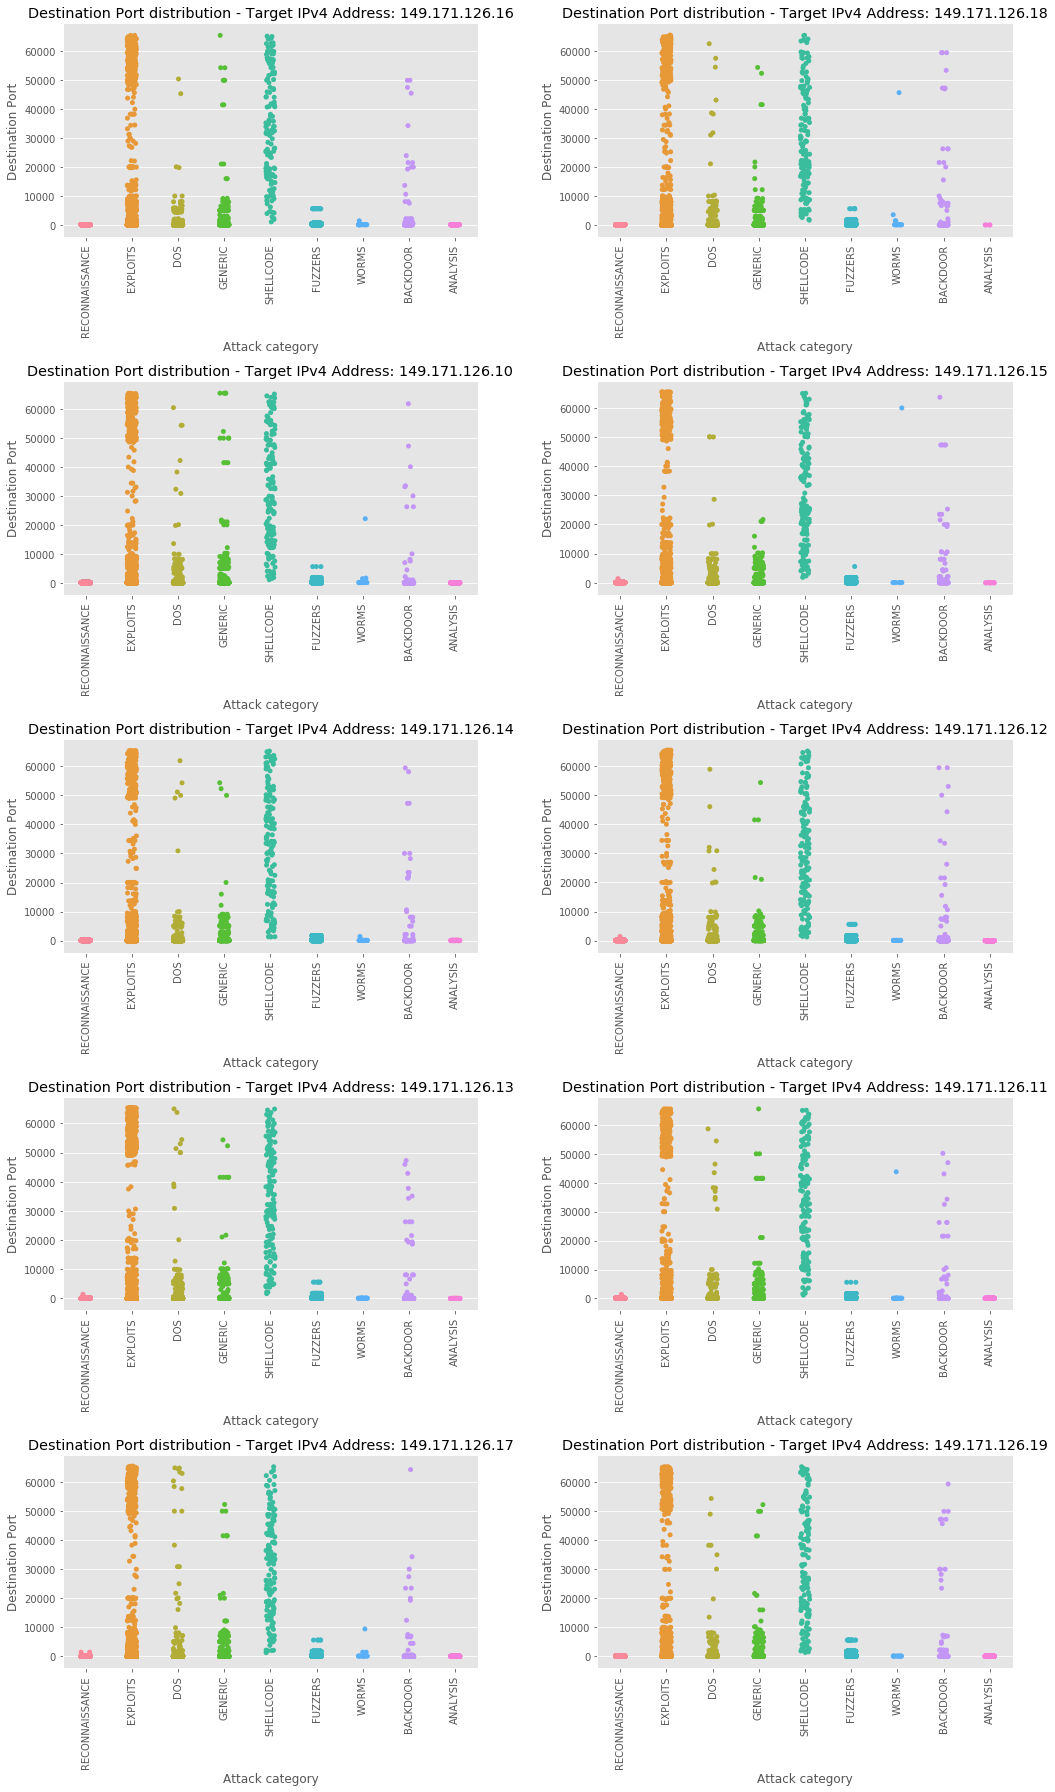

In [144]:
ips = list(newdf['Destination IP'].unique())
f, axes = plt.subplots(5, 2)
f.set_figheight(25)
f.set_figwidth(15)

labels = list(newdf['Attack category'].unique())

for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=newdf[newdf['Destination IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Target IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

These graphs show us that there is a differentiation in the way in which the attacks are performing their tasks. There is a particularization by the targets, something that does not happen with the source devices.

In [147]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted)
threshold = thresholds[np.argmax(tpr-fpr)]
print("FPR = ", fpr)
print("TPR = ", tpr)
print("threshold = ", threshold)

print('Train auc =', auc(fpr, tpr))

FPR =  [0. 0. 1.]
TPR =  [0. 1. 1.]
threshold =  1
Train auc = 1.0
